In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import pandas as pd

In [2]:
#start by reading the images from file
imgs=[tifffile.imread('example_data/003003-1-00100100'+str(i)+'.tif') for i in range(1,4)]

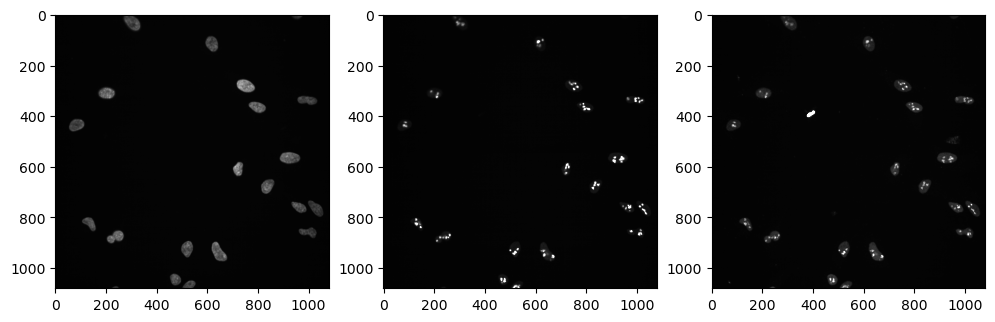

In [3]:
#show the images
fig,axs=plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(imgs[0],vmin=0,vmax=10000,cmap='gray')
axs[1].imshow(imgs[1],vmin=0,vmax=10000,cmap='gray')
axs[2].imshow(imgs[2],vmin=0,vmax=10000,cmap='gray')

In [4]:
#this cell has all of the functions we need to do the processing and measurements

#this is the structuring element for flood fill labeling
#full structure means diagonal pixels will get connected
fs=np.ones((3,3))

def poorMansRollingBall(img,rollballrad=100,smstdev=5):
    '''
    we don't have an easy to use rolling ball option in python so subtract a smoothed 
    minimum filtered image instead
    '''
    fimg=img.astype(float)
    return fimg-ndi.minimum_filter(ndi.gaussian_filter(fimg,sigma=smstdev),size=rollballrad*2)

def labelClearEdges(mask,border=2):
    '''
    clear objects within border distance of the edge and label them (return nobjects as well)
    '''
    labels=ndi.label(mask,structure=fs)[0]
    edge=np.concatenate([labels[:border,:].flat,labels[-border:,:].flat,
                         labels[:,:border].flat,labels[:,-border:].flat])
    edgevals=np.unique(edge)
    filtered=labels.copy()
    for i in range(len(edgevals)):
        if(edgevals[i]!=0):
            filtered[labels==edgevals[i]]=0.0
    return ndi.label(filtered>0.5,structure=fs)

def filterObjects(labels,nobj,minsize=4,maxsize=-1,fillholes=True):
    '''
    filter out large and small objects from a labeled image (return nobjects as well)
    '''
    objareas=ndi.sum(labels>0.5,labels,range(1,nobj+1))
    filtered=labels.copy()
    for i in range(len(objareas)):
        if(objareas[i]<minsize):
            filtered[labels==(i+1)]=0.0
        elif(maxsize>0 and objareas[i]>maxsize):
            filtered[labels==(i+1)]=0.0
    filled=ndi.binary_fill_holes(filtered>0.5,structure=fs)
    return ndi.label(filled>0.5,structure=fs)

def segmentNuclei(dapiimg,rollballrad=100,smstdev=5,nucthresh=0.1,minsize=1000,maxsize=4000):
    '''
    segment the nuclei and return preprocessed, unfiltered mask,filtered labels and number of nuclei
    '''
    dapisub=poorMansRollingBall(dapiimg,rollballrad=rollballrad,smstdev=smstdev)
    #threshold at fraction of max
    dapimask=dapisub>(nucthresh*dapisub.max())
    #eliminate the edge objects and label them
    dapilabels,nnuclei=labelClearEdges(dapimask)
    #filter out large and small nuclei
    dapilabels,nnuclei=filterObjects(dapilabels,nnuclei,minsize=minsize,maxsize=maxsize)
    return dapisub,dapimask,dapilabels,nnuclei

def segmentNucleoli(nuclimg,thirdimg,dapilabels,nnuclei,
                    rollballrad=15.0,rbsigma=1.0,sigma=0.7,nuclthresh=0.4,minnuclsize=4):
    '''
    segment the nucleoli and return preprocessed, preprocessed third, labeled, and nnuceoli
    note that "third" is a third image (not nuceoli or nuclei) that needs measured
    '''
    #start with background subtraction
    nucleolisub=poorMansRollingBall(nuclimg,rollballrad=rollballrad,smstdev=rbsigma)
    thirdsub=poorMansRollingBall(thirdimg,rollballrad=rollballrad,smstdev=rbsigma)
    #and a filter
    nucleoli=ndi.gaussian_filter(nucleolisub,sigma=sigma)
    third=ndi.gaussian_filter(thirdsub,sigma=sigma)
    #get the min and max values for each nucleus
    minvals=ndi.minimum(nucleoli,labels=dapilabels,index=range(1,nnuclei+1))
    maxvals=ndi.maximum(nucleoli,labels=dapilabels,index=range(1,nnuclei+1))
    threshvals=minvals+nuclthresh*(maxvals-minvals)
    #make the threshold mask
    threshlevels=dapilabels.copy()
    for i in range(len(threshvals)):
        threshlevels[dapilabels==(i+1)]=threshvals[i]
    #apply the mask in areas where there are nuclei
    nucleolimask=nucleoli>threshlevels
    nucleolimask[threshlevels==0.0]=0
    nucleolilabels,nnucleoli=ndi.label(nucleolimask,structure=fs)
    #finally filter out the small nucleoli
    nucleolilabels,nnucleoli=filterObjects(nucleolilabels,nnucleoli,minsize=minnuclsize,fillholes=False)
    return nucleoli,third,nucleolilabels,nnucleoli

def measureAll(dapilabels,nnuclei,nucleolilabels,nnucleoli,nucleoli,third):
    '''
    measure all of the nucleoli and associate them with their parent nucleus
    '''
    nuclear_means=ndi.mean(nucleoli,dapilabels,range(1,nnuclei+1))
    nuclear_stds=ndi.standard_deviation(nucleoli,dapilabels,range(1,nnuclei+1))
    #use the ndimage sum function with a boolean image to get the area
    nuclear_areas=ndi.sum(dapilabels>0.5,dapilabels,range(1,nnuclei+1))
    nucleolar_means=ndi.mean(nucleoli,nucleolilabels,range(1,nnucleoli+1))
    nucleolar_stds=ndi.standard_deviation(nucleoli,nucleolilabels,range(1,nnucleoli+1))
    nucleolar_areas=ndi.sum(nucleolilabels>0.5,nucleolilabels,range(1,nnucleoli+1))
    #measure the dapi label "intensity" in each nucleolus to get it's parent label
    nucleolar_ids=ndi.mean(dapilabels,nucleolilabels,range(1,nnucleoli+1))
    #now measure the third image
    third_means=ndi.mean(third,nucleolilabels,range(1,nnucleoli+1))
    third_stds=ndi.standard_deviation(third,nucleolilabels,range(1,nnucleoli+1))
    thirdnuc_means=ndi.mean(third,dapilabels,range(1,nnuclei+1))
    thirdnuc_stds=ndi.standard_deviation(third,dapilabels,range(1,nnuclei+1))
    #count the number of nucleoli per nucleus
    nucleolar_count=[0]*nnuclei
    for i in range(nnucleoli):
        nid=int(np.round(nucleolar_ids[i]))-1
        nucleolar_count[nid]+=1
    #now get the measurements for every nucleolus as a dictionary
    #nuclear measurements: nucleolar_id, nucid, area, avg, stdev, nucleolar count; nucleolar measurements: area, avg, stdev,thirdnucavg,thirdnucstdev,thirdavg,thirdstdev
    measurements=[]
    for i in range(nnucleoli):
        nid=int(np.round(nucleolar_ids[i]))-1
        mdict={'id':i,'nuclear_id':nid+1,'nuclear_area':nuclear_areas[nid],'nuclear_avg':nuclear_means[nid],
               'nuclear_stdev':nuclear_stds[nid],'number_nucleoli':nucleolar_count[nid],'nucleolar_area':nucleolar_areas[i],
               'nucleolar_avg':nucleolar_means[i],'nucleolar_stdev':nucleolar_stds[i],'third_nucavg':thirdnuc_means[nid],
               'third_nucstdev':thirdnuc_stds[nid],'third_nuclavg':third_means[i],'third_nuclstdev':third_stds[i]}
        measurements.append(mdict)
    #return as a dataframe
    return pd.DataFrame(measurements)

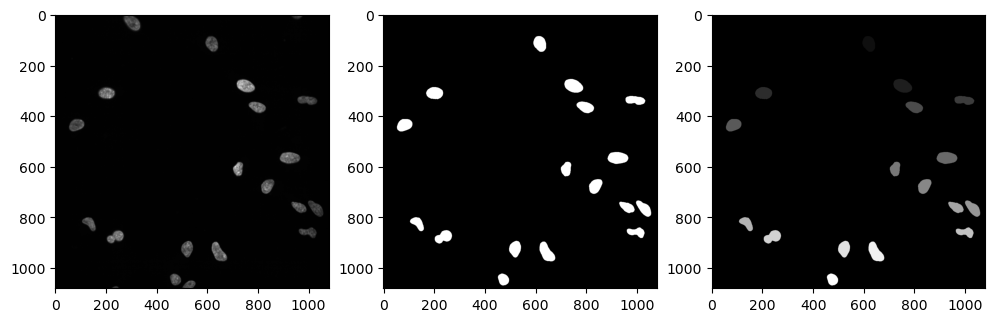

In [5]:
#filter the nuclei
dapisub,dapimask,dapilabels,nnuclei=segmentNuclei(imgs[0])
fig,axs=plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(dapisub,cmap='gray')
axs[1].imshow(dapilabels>0.5,cmap='gray')
axs[2].imshow(dapilabels,cmap='gray')

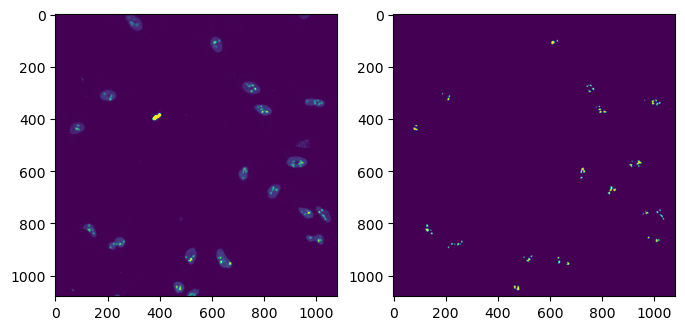

In [6]:
#now segment the nucleoli
nucleoli,third,nucleolilabels,nnucleoli=segmentNucleoli(imgs[2],imgs[1],dapilabels,nnuclei)
fig,axs=plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(nucleoli,vmax=10000)
axs[1].imshow(nucleolilabels>0.5)

In [7]:
#finally get the measurements
df=measureAll(dapilabels,nnuclei,nucleolilabels,nnucleoli,nucleoli,third)
df.to_csv('img_measurements.csv')

In [8]:
df.head()

,id,nuclear_id,nuclear_area,nuclear_avg,nuclear_stdev,number_nucleoli,nucleolar_area,nucleolar_avg,nucleolar_stdev,third_nucavg,third_nucstdev,third_nuclavg,third_nuclstdev
0,0,1,2410.0,1522.423268,1455.759119,2,26.0,4929.816548,755.623877,1296.417575,2285.924745,6297.444119,1026.167695
1,1,1,2410.0,1522.423268,1455.759119,2,135.0,6465.998136,1627.561479,1296.417575,2285.924745,9216.298214,2509.037986
2,2,2,3006.0,1556.982159,1696.827323,5,10.0,6076.138290,607.914783,1403.773721,2337.835445,5458.711977,498.735120
3,3,2,3006.0,1556.982159,1696.827323,5,29.0,7617.586642,1592.930798,1403.773721,2337.835445,9013.172040,1986.515250
4,4,2,3006.0,1556.982159,1696.827323,5,23.0,7103.205879,1397.099696,1403.773721,2337.835445,7795.831612,1204.371766


In [9]:
#finally write the masks to tif files for reference
tifffile.imwrite('dapi_mask.tif',dapilabels>0.5)
tifffile.imwrite('nucleolar_mask.tif',nucleolilabels>0.5)